=== Handle imports and paths ===

In [1]:
import sys
sys.path.append('/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/') 
sys.path.append('/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/functions/') 
from paths_and_imports import *
from control_flow_functions import *
from nn_optim_unet import *
from postprocessing import *
from dataset_config import datasets
%load_ext autoreload
%autoreload 2

/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/env_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Load the trained model ===

In [2]:
trained_model = get_gnn(fs=feature_scale, dropout_levels=dropout_levels, 
                           pooling_path=pooling_path, ico_levels=ico_levels)    
trained_model.load_state_dict(torch.load(f'{output_dir}trained_weights.pth'))

<All keys matched successfully>

=== Test model accuracy with randomized feature values per-feature (ablation) ===

In [18]:
suffix='test_CN' # which set is ablated
ablation_dict, per_subject_dict = ablate_model(X_test_CN, y_test_CN, model=trained_model, suffix=suffix)

MAE (L1) Loss: 7.333 across 1128 observations
Variance and MAE Loss: 95.428 across 1128 observations
MAE (L1) Loss: 11.542 across 1128 observations
Variance and MAE Loss: 199.899 across 1128 observations
MAE (L1) Loss: 7.091 across 1128 observations
Variance and MAE Loss: 91.425 across 1128 observations
MAE (L1) Loss: 7.084 across 1128 observations
Variance and MAE Loss: 90.044 across 1128 observations
MAE (L1) Loss: 10.445 across 1128 observations
Variance and MAE Loss: 169.350 across 1128 observations
MAE (L1) Loss: 7.568 across 1128 observations
Variance and MAE Loss: 100.224 across 1128 observations




In [ ]:
suffix='test_CN' # which set is ablated
with open(f"{output_dir}{suffix}_ablation_dict.pkl", "rb") as f:
    ablation_dict = pickle.load(f)
    ablation_dict['WM-GM ratio'] = ablation_dict.pop('w-g.pct.mgh')

# Reorder ablation dict
ablation_dict = {k: ablation_dict[k] for k in ['area', 'thickness', 'WM-GM ratio', 'curv', 'sulc']}

# Set cbar lims, ordered
cbar_lims = [100, 100, 100, 50, 50, 50]

paths = []
path_titles = []

idx = 1
for key, lim in zip(ablation_dict.keys(), cbar_lims):
    
    # Process cortical plots
    p = postprocess(suffix=suffix)
    processed_ablation, mask = p.remove_medial_wall(ablation_dict[key][None, :]) # Remove the medial wall
    processed_ablation = p.clip_outliers(processed_ablation) # Clip the outliers (1st to 99th percentile)
    processed_ablation, _, _ = p.smooth_vertex_data(processed_ablation, np.zeros_like(processed_ablation.squeeze()), mask) # smoothed values
    p.get_matlab(processed_ablation.squeeze(), output_path=f'{p.output_dir}{p.suffix}_{key}_ablation')

    mat_files = [f'{p.output_dir}{suffix}_{key}_ablation']
    matlab_file_list = "{" + ",".join([f"'{f}'" for f in mat_files]) + "}"
    
    # If last column, show cbar
    if idx % 3 == 0:
        cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'lat_L','lat_R','med_R','med_L'}}, {lim}); exit"]
    else:
        cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'lat_L','lat_R','med_R','med_L'}}, {lim}, false); exit"]
    result = subprocess.run(cmd, cwd="/mnt/md0/tempFolder/samAnderson/nahian_code/", stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Add paths and title to list
    paths.append(f'{p.output_dir}{p.suffix}_{key}_ablation_latL_latR_medR_medL.png')
    path_titles.append(key)
    idx+=1
    
    if key == 'area':
        if idx % 3 == 0:
            cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'ant','dor','pos','ven'}}, {lim}); exit"]
        else:
            cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'ant','dor','pos','ven'}}, {lim}, false); exit"]
        result = subprocess.run(cmd, cwd="/mnt/md0/tempFolder/samAnderson/nahian_code/", stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        paths.append(f'{p.output_dir}{p.suffix}_{key}_ablation_ant_dor_pos_ven.png')
        path_titles.append('')
        idx+=1

paths

['/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_area_ablation_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_area_ablation_ant_dor_pos_ven.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_thickness_ablation_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_WM-GM ratio_ablation_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_curv_ablation_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_sulc_ablation_latL_latR_medR_medL.png']

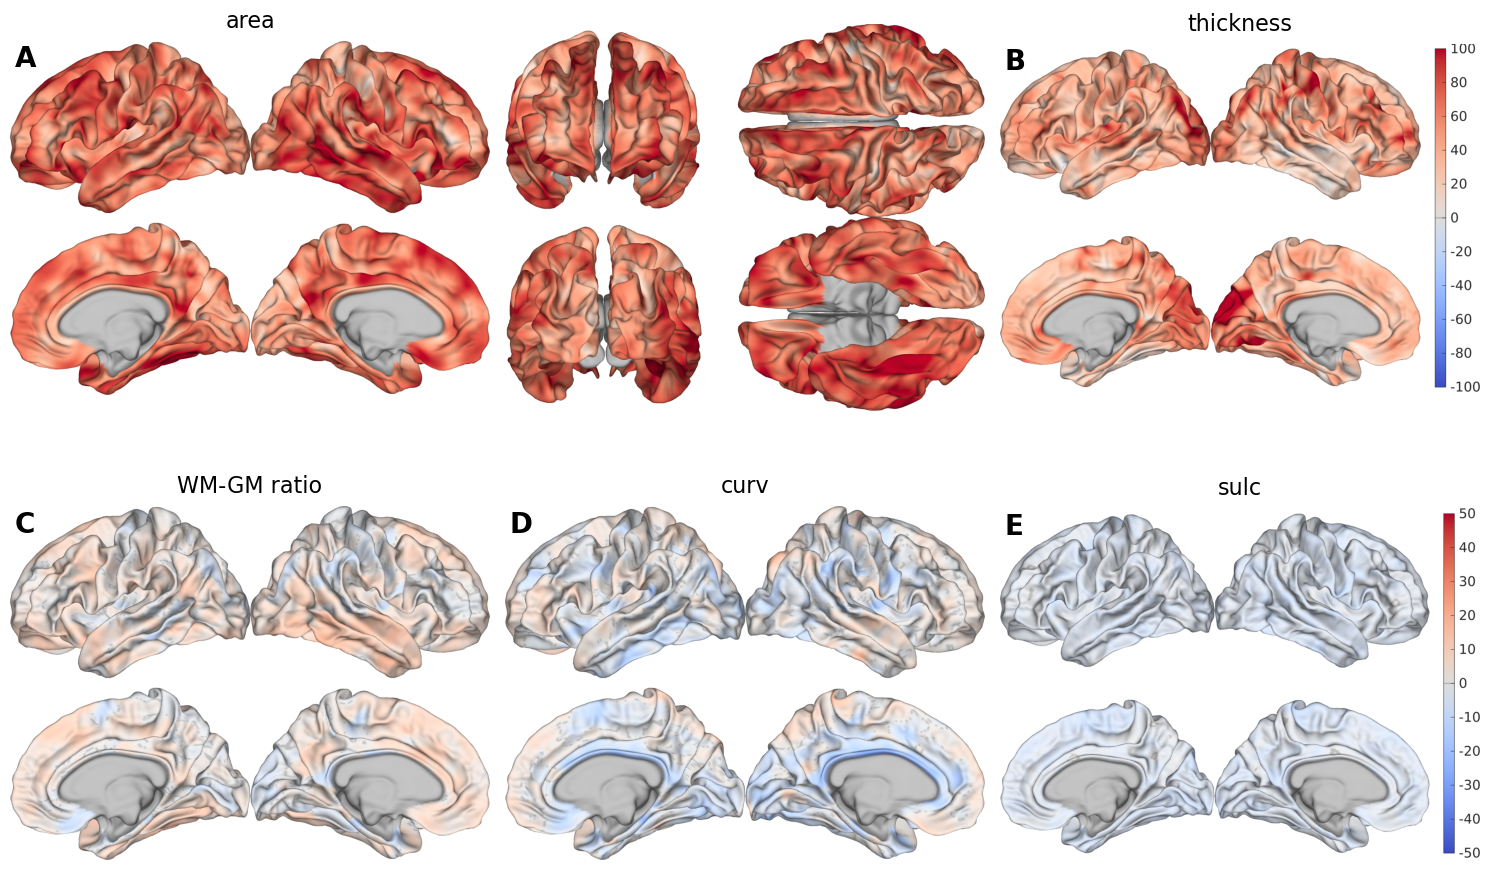

In [9]:
# Labels for the subplots
subplot_labels = ['A', '', 'B', 'C', 'D', 'E']

# Assume 'paths' is your list of 5 image file paths
# Create a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # Flatten to 1D for easy indexing

# Plot images
for i, ax in enumerate(axes):
    if i < len(paths):  # Only plot if there is an image
        img = mpimg.imread(paths[i])
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.01, 0.99, subplot_labels[i], transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top', ha='left',
                bbox=dict(facecolor='white', edgecolor='none'))
        ax.set_title(path_titles[i], fontsize=16, pad=10)
    else:
        ax.axis('off')  # Hide any empty axes

plt.tight_layout()

Get the average per-lobe per-feature percent difference in MAE

In [20]:
suffix='test_CN' # which set is ablated
with open(f"{output_dir}{suffix}_ablation_dict.pkl", "rb") as f:
    ablation_dict = pickle.load(f)

rows = []
for key, array in ablation_dict.items():
    
    # Skip baseline
    if key == 'baseline': continue
    
    # Get averages per feature and lobe
    lobe_avg = postprocess().lobe_avgs(array[np.newaxis, :])
    
    # Round and format as X.XX%
    lobe_avg_formatted = {lobe: f"{v:.2f}%" for lobe, v in lobe_avg.items()}
    
    # Add feature name
    lobe_avg_formatted['feature'] = key
    rows.append(lobe_avg_formatted)

# Create df
df = pd.DataFrame(rows)
cols = ['feature'] + [c for c in df.columns if c != 'feature']
df = df[cols]
df

,feature,temporal,parietal,frontal,occipital
0,baseline,7.39%,6.95%,7.04%,7.16%
1,area,69.03%,58.18%,65.17%,54.43%
2,curv,-1.95%,0.22%,0.79%,-2.23%
3,sulc,-3.85%,-2.78%,-3.16%,-3.62%
4,thickness,34.44%,46.26%,40.56%,58.49%
5,WM-GM_ratio,8.93%,3.67%,7.27%,5.05%


=== Run integrated grad too determine feature significance ===

In [ ]:
suffix='test_CN' # which set is grad
grad_array = integrated_grad(X_test_CN, y_test_CN, model=trained_model, test_size=128, suffix=suffix) # larger size since its so slow
np.save(f'{output_dir}{suffix}_integrated_grad.npy', grad_array)

In [11]:
suffix='test_CN' # which set is grad
grad_array = np.load(f'{output_dir}{suffix}_integrated_grad.npy')
avg_grad = np.mean(grad_array, axis=0)
avg_grad.shape

# Create grad dict
grad_dict = {}
for idx, feature in enumerate(['area','curvature','sulcal_depth', 'thickness', 'WM-GM_ratio']):
    grad_dict[feature] = avg_grad[:, idx]

paths = []
path_titles = []

for feature in grad_dict:
    
    # Process cortical plots
    p = postprocess(suffix=suffix)
    processed_grad, mask = p.remove_medial_wall(grad_dict[feature][None, :]) # Remove the medial wall
    processed_grad = p.clip_outliers(processed_grad) # Clip the outliers (1st to 99th percentile)
    processed_grad, _, _ = p.smooth_vertex_data(processed_grad, np.zeros_like(processed_grad.squeeze()), mask) # smoothed values
    p.get_matlab(processed_grad.squeeze(), output_path=f'{p.output_dir}{p.suffix}_{feature}_grad')
    mat_files = [f'{p.output_dir}{p.suffix}_{feature}_grad']
    matlab_file_list = "{" + ",".join([f"'{f}'" for f in mat_files]) + "}"

    # If last column, show cbar
    cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'lat_L','lat_R','med_R','med_L'}}); exit"]
    result = subprocess.run(cmd, cwd="/mnt/md0/tempFolder/samAnderson/nahian_code/", stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Add paths and title to list
    paths.append(f'{p.output_dir}{p.suffix}_{feature}_grad_latL_latR_medR_medL.png')
    path_titles.append(feature)

paths

['/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_area_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_curvature_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_sulcal_depth_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_thickness_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_WM-GM_ratio_grad_latL_latR_medR_medL.png']

In [17]:
# Get essential files
suffix='test_CN' # which set is grad
grad_array = np.load(f'{output_dir}{suffix}_integrated_grad.npy')
avg_grad = np.mean(grad_array, axis=0)

# Create the grad dict
grad_dict = {}
for idx, key in enumerate(['area', 'curvature','sulcal_depth', 'thickness', 'WM-GM_ratio']):
    grad_dict[key] = avg_grad[:, idx]

# Reorder the grad dict
grad_dict = {k: grad_dict[k] for k in ['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth']}

# Set cbar lims, ordered
cbar_lims = [25, 25, 10, 10, 10]

paths = []
path_titles = []

idx = 1
for key, lim in zip(grad_dict.keys(), cbar_lims):
    
    # Process cortical plots
    p = postprocess(suffix=suffix)
    processed_grad, mask = p.remove_medial_wall(grad_dict[key][None, :]) # Remove the medial wall
    processed_grad = p.clip_outliers(processed_grad) # Clip the outliers (1st to 99th percentile)
    processed_grad, _, _ = p.smooth_vertex_data(processed_grad, np.zeros_like(processed_grad.squeeze()), mask) # smoothed values
    p.get_matlab(processed_grad.squeeze(), output_path=f'{p.output_dir}{p.suffix}_{key}_integrated_grad')
    
    mat_files = [f'{p.output_dir}{p.suffix}_{key}_integrated_grad']
    matlab_file_list = "{" + ",".join([f"'{f}'" for f in mat_files]) + "}"
    
    # If last column, show cbar
    if idx % 3 == 0:
        cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'lat_L','lat_R','med_R','med_L'}}, {lim}); exit"]
    else:
        cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'lat_L','lat_R','med_R','med_L'}}, {lim}, false); exit"]
    result = subprocess.run(cmd, cwd="/mnt/md0/tempFolder/samAnderson/nahian_code/", stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Add paths and title to list
    paths.append(f'{p.output_dir}{p.suffix}_{key}_integrated_grad_latL_latR_medR_medL.png')
    path_titles.append(key)
    idx+=1
    
    if key == 'area':
        if idx % 3 == 0:
            cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'ant','dor','pos','ven'}}, {lim}); exit"]
        else:
            cmd = ["matlab", "-nodisplay", "-nosplash", "-r", f"generate_brain({matlab_file_list}, {{'ant','dor','pos','ven'}}, {lim}, false); exit"]
        result = subprocess.run(cmd, cwd="/mnt/md0/tempFolder/samAnderson/nahian_code/", stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        paths.append(f'{p.output_dir}{p.suffix}_{key}_integrated_grad_ant_dor_pos_ven.png')
        path_titles.append('')
        idx+=1

paths

['/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_area_integrated_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_area_integrated_grad_ant_dor_pos_ven.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_thickness_integrated_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_WM-GM_ratio_integrated_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_curvature_integrated_grad_latL_latR_medR_medL.png',
 '/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/last_model_outputs/test_CN_sulcal_depth_integrated_grad_latL_latR_medR_medL.png']

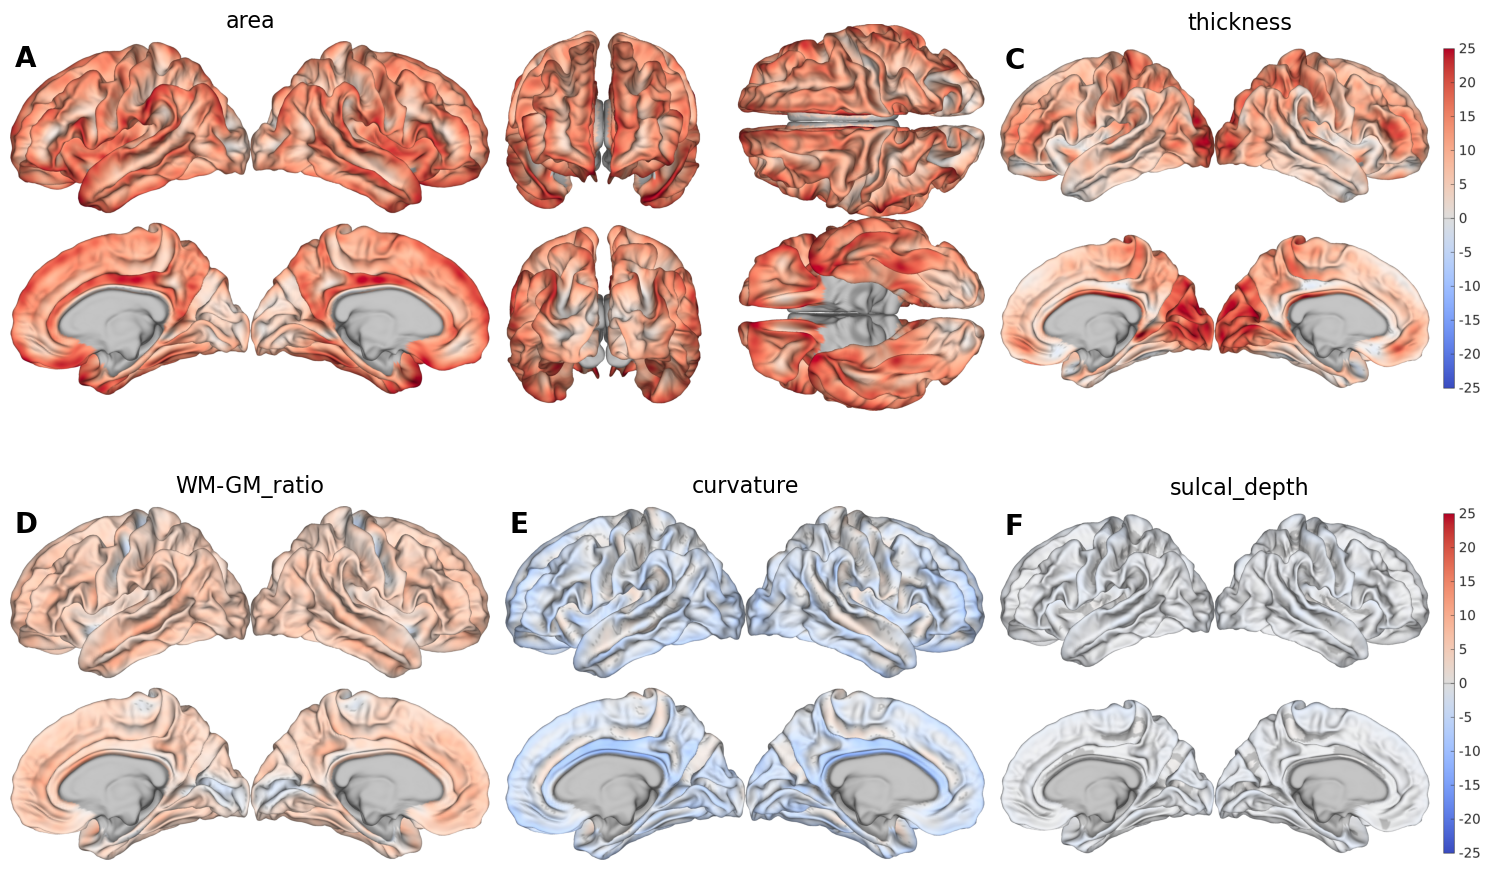

In [23]:
# Labels for the subplots
subplot_labels = ['A', '', 'C', 'D', 'E', 'F']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # Flatten to 1D for easy indexing

# Plot images
for i, ax in enumerate(axes):
    if i < len(paths):  # Only plot if there is an image
        img = mpimg.imread(paths[i])
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.01, 0.99, subplot_labels[i], transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top', ha='left',
                bbox=dict(facecolor='white', edgecolor='none'))
        ax.set_title(path_titles[i], fontsize=16, pad=10)
    else:
        ax.axis('off')  # Hide any empty axes

plt.tight_layout()

In [22]:
# Get essential files
suffix='test_CN' # which set is grad
grad_array = np.load(f'{output_dir}{suffix}_integrated_grad.npy')
avg_grad = np.mean(grad_array, axis=0)

# Create the grad dict
grad_dict = {}
for idx, key in enumerate(['area', 'curvature','sulcal_depth', 'thickness', 'WM-GM_ratio']):
    grad_dict[key] = avg_grad[:, idx]

rows = []
for key, array in grad_dict.items():
    
    # Get averages per feature and lobe
    lobe_avg = postprocess().lobe_avgs(array[np.newaxis, :])
    
    # Round and format as X.XX%
    lobe_avg_formatted = {lobe: v for lobe, v in lobe_avg.items()}
    
    # Add feature name
    lobe_avg_formatted['feature'] = key
    rows.append(lobe_avg_formatted)

# Create df
df = pd.DataFrame(rows)
cols = ['feature'] + [c for c in df.columns if c != 'feature']
df = df[cols]
df

,feature,temporal,parietal,frontal,occipital
0,area,13.100756,11.494273,13.380514,8.921553
1,curvature,-1.964379,-1.790925,-2.832527,-2.657396
2,sulcal_depth,-0.646502,-0.554410,-0.686622,-0.756332
3,thickness,6.105230,10.760329,8.533125,15.012109
4,WM-GM_ratio,5.000370,4.944043,5.686736,4.312794
